# CSC 594: Deep Generative Models Final Project

## Comparing RL Algorithms and Hyperparameter Effects in Gymnasium Environments

## Team Members
- Esteban Montelongo <EMONTEL1@depaul.edu>
- Abhaya Basnet <ABASNET@depaul.edu>
- James Evarts <JEVARTS@depaul.edu>

**Abstract (from Proposal):**
> Reinforcement learning (RL) algorithms often perform differently depending on the environment and tuning of their hyperparameters. In this project, we compare three popular RL methods—Deep Q-Networks (DQN), Proximal Policy Optimization (PPO), and Advantage Actor-Critic (A2C)—in a modern Gymnasium environment. We study how different algorithms learn under the same conditions and analyze how tweaking key hyperparameters affects learning speed and final performance. The goal is to provide clear, reproducible insights for practitioners using off-the-shelf RL tools.

In [1]:
# -----------------------------------------------------------
# Section 0: Project Setup – Imports and Global Configuration
#
# This cell imports necessary libraries and sets up global parameters
# aligned with the project proposal dated May 2, 2025, targeting an Atari environment.
# -----------------------------------------------------------

# --- Core Libraries ---
import os
import random
import time
import warnings

import ale_py
import cv2
import gymnasium as gym
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Reinforcement Learning Libraries ---
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.env_util import make_atari_env # Specialized for Atari
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage # Crucial for Atari
from stable_baselines3.common.monitor import Monitor # For wrapping environments
from stable_baselines3.common.callbacks import EvalCallback

# --- Experiment Tracking & Hyperparameter Optimization ---
import wandb
from wandb.integration.sb3 import WandbCallback
import optuna

# --- Optional: Torchvision (if using custom CNNs or its components) ---
# from torchvision import models

# ===========================================================
#               GLOBAL PROJECT CONFIGURATION
# ===========================================================

# --- 1. Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f"Global SEED set to: {SEED}")

# --- 2. Computational Device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 3. Environment Configuration ---
# This requires `pip install gymnasium[atari] gymnasium[accept-rom-license]`
ENV_ID = "ALE/Breakout-v5"
# Default policy for image-based envs like Atari will be "CnnPolicy"
POLICY_TYPE = "CnnPolicy"
print(f"Selected Environment ID: {ENV_ID}")
print(f"Default Policy Type for this environment: {POLICY_TYPE}")

# --- 4. Training Parameters (from Proposal Section 3.2) ---
TOTAL_STEPS = 100000
N_SEEDS_PER_ALGO = 3
print(f"Total training steps per run: {TOTAL_STEPS}")
print(f"Number of seeds per algorithm: {N_SEEDS_PER_ALGO}")

# Optuna trials (from Proposal Section 3.3)
N_OPTUNA_TRIALS_PER_ALGO = 5
print(f"Number of Optuna trials per algorithm: {N_OPTUNA_TRIALS_PER_ALGO}")

# --- 5. Output & Logging Configuration ---
RESULTS_DIR = "outputs_breakout" # Changed to specify breakout
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Results will be saved in: ./{RESULTS_DIR}/")

# W&B Project Name
WANDB_PROJECT_NAME = "csc594_final_project"
print(f"Weights & Biases Project Name: {WANDB_PROJECT_NAME}")

# --- 6. Atari Specific Configuration (can be adjusted) ---
N_ENVS_ATARI = 4  # Number of parallel Atari environments for make_atari_env
                  # Using multiple environments speeds up Atari training significantly.
                  # Your proposal mentions "Each run will last 50,000-100,000 environment steps"
                  # This usually means total steps across all parallel envs.
FRAME_STACK_ATARI = 4 # Number of frames to stack
print(f"Number of parallel Atari environments (n_envs): {N_ENVS_ATARI}")
print(f"Number of stacked frames for Atari: {FRAME_STACK_ATARI}")

# --- 7. Warning Hygiene ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
print("Warning filters configured.")

# ===========================================================
print("\nGlobal setup complete for Breakout.")

Global SEED set to: 42
Using device: cpu
Selected Environment ID: ALE/Breakout-v5
Default Policy Type for this environment: CnnPolicy
Total training steps per run: 100000
Number of seeds per algorithm: 3
Number of Optuna trials per algorithm: 5
Results will be saved in: ./outputs_breakout/
Weights & Biases Project Name: csc594_final_project
Number of parallel Atari environments (n_envs): 4
Number of stacked frames for Atari: 4
Warning filters configured.

Global setup complete for Breakout.


d:\workdir\school_repos\rl_project\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.1 is exactly one major version older than the runtime version 6.31.1 at api.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(


## 1. Introduction to Libraries

This project utilizes several key Python libraries for reinforcement learning research and development:

- **NumPy:** The fundamental package for numerical computation in Python. It's used for handling arrays and matrices, which are essential for representing states (especially image-based observations from Atari), actions, and other data in RL.
- **PyTorch:** An open-source deep learning framework. In this project, PyTorch is used by Stable-Baselines3 to define and train the Convolutional Neural Networks (CNNs) that act as policy and/or value functions for our RL agents operating in image-based environments like Atari Breakout. *Note: TensorFlow is not used for neural network implementation in this project, as per course requirements.*
- **Gymnasium (formerly OpenAI Gym):** A toolkit for developing and comparing reinforcement learning algorithms. It provides a standardized interface to a wide variety of simulated environments. We will be using an Atari environment (`ALE/Breakout-v5`) from the Arcade Learning Environment (ALE) provided through Gymnasium. This requires the `gymnasium[atari]` extra.
- **Stable-Baselines3 (SB3):** A set of reliable implementations of reinforcement learning algorithms in PyTorch. We will be using its implementations of Deep Q-Network (DQN), Proximal Policy Optimization (PPO), and Advantage Actor-Critic (A2C), employing `CnnPolicy` for the Atari environment.
- **Optuna:** An automatic hyperparameter optimization framework. It will be used to search for optimal hyperparameters for our RL agents.
- **Weights & Biases (W&B):** An MLOps platform for experiment tracking, dataset versioning, and model management. We will use W&B to log training progress, compare different experimental runs, and visualize results.
- **Matplotlib:** A comprehensive library for creating static, interactive, and animated visualizations in Python. It will be used to plot learning curves and other relevant metrics.
- **Torchvision:** A PyTorch package that consists of popular datasets, model architectures, and common image transformations for computer vision. While SB3's `CnnPolicy` handles much of the network structure, `torchvision` might be referenced if we were to implement highly custom CNN backbones (though the project proposal focuses on SB3 defaults and `policy_kwargs` for network size adjustments).

**Installation:**
All required libraries and project dependencies are specified in the `requirements.txt` file. Core dependencies can be installed by running `pip install -r requirements.txt` in the activated virtual environment (`.venv`) from the project root.

In [2]:
# Ensure ENV_ID, SEED, N_ENVS_ATARI, FRAME_STACK_ATARI are defined from Section 0
# ENV_ID = "ALE/Breakout-v5"
# POLICY_TYPE = "CnnPolicy"
# N_ENVS_ATARI = 4
# FRAME_STACK_ATARI = 4

print(f"--- Inspecting Raw Environment: {ENV_ID} ---")
# Create a single raw instance for basic inspection
raw_env_inspect = gym.make(ENV_ID)
print(f"Raw Observation Space: {raw_env_inspect.observation_space}")
print(f"Raw Action Space: {raw_env_inspect.action_space}")
print(f"Raw Action Space Meanings: {raw_env_inspect.unwrapped.get_action_meanings()}")
# Reward range might not be directly available or always accurate for raw Atari
if hasattr(raw_env_inspect.unwrapped, 'reward_range'):
    print(f"Raw Reward Range: {raw_env_inspect.unwrapped.reward_range}")
else:
    print(f"Raw Reward Range: Attribute not directly available on unwrapped env.")
raw_env_inspect.close()

print(f"\n--- Inspecting Wrapped & Vectorized Environment for Training ---")
# Create the environment as it would be used for training with SB3
# make_atari_env applies several wrappers.
# We'll wrap it with VecTransposeImage before VecFrameStack if make_atari_env doesn't handle final channel order.
# However, make_atari_env usually sets up the env correctly for SB3's CnnPolicy.

# Create a dummy vectorized environment using make_atari_env
# The 'wrapper_kwargs' can be used to pass arguments to wrappers like FrameStack if not done separately
# For SB3, VecFrameStack is typically applied *after* make_atari_env.

# Step 1: Create multiple Atari environments with standard wrappers
vec_env_pre_stack = make_atari_env(ENV_ID, n_envs=N_ENVS_ATARI, seed=SEED)

# Step 2: Apply Frame Stacking
# VecTransposeImage is often implicitly handled by SB3 CnnPolicy or make_atari_env,
# but if obs are (H, W, C*N_STACK), CnnPolicy might expect (N_STACK*C, H, W).
# SB3's CnnPolicy usually expects channels-first input. make_atari_env typically
# uses LazyFrames which are (H,W,C), and VecFrameStack stacks them along a new channel dim
# which SB3 policies then handle.

vec_env_final_inspect = VecFrameStack(vec_env_pre_stack, n_stack=FRAME_STACK_ATARI)

print(f"Final (Stacked) Observation Space: {vec_env_final_inspect.observation_space}")
print(f"  Shape: {vec_env_final_inspect.observation_space.shape} (NumEnvs, Height, Width, Channels*NumStack) or (NumEnvs, Channels*NumStack, Height, Width)")
print(f"  Data Type: {vec_env_final_inspect.observation_space.dtype}")
print(f"Action Space (from vectorized env): {vec_env_final_inspect.action_space}")

# Sample interaction with the final vectorized and stacked environment
print("\nSample interaction with final processed environment:")
obs_final_vec = vec_env_final_inspect.reset()
print(f"  Initial observation shape (final, vectorized, stacked): {obs_final_vec.shape}")

# For Atari, actions are usually single integers for each env in the vector
random_actions = [vec_env_final_inspect.action_space.sample() for _ in range(N_ENVS_ATARI)]
next_obs_final_vec, rewards_vec, dones_vec, infos_vec = vec_env_final_inspect.step(random_actions)
print(f"  Actions taken (vectorized): {random_actions}")
print(f"  Next observation shape (final, vectorized, stacked): {next_obs_final_vec.shape}")
print(f"  Rewards received (vectorized): {rewards_vec}")
print(f"  Dones received (vectorized): {dones_vec}")

# Close the vectorized environment
vec_env_final_inspect.close() # This will also close vec_env_pre_stack

--- Inspecting Raw Environment: ALE/Breakout-v5 ---
Raw Observation Space: Box(0, 255, (210, 160, 3), uint8)
Raw Action Space: Discrete(4)
Raw Action Space Meanings: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']
Raw Reward Range: Attribute not directly available on unwrapped env.

--- Inspecting Wrapped & Vectorized Environment for Training ---
Final (Stacked) Observation Space: Box(0, 255, (84, 84, 4), uint8)
  Shape: (84, 84, 4) (NumEnvs, Height, Width, Channels*NumStack) or (NumEnvs, Channels*NumStack, Height, Width)
  Data Type: uint8
Action Space (from vectorized env): Discrete(4)

Sample interaction with final processed environment:
  Initial observation shape (final, vectorized, stacked): (4, 84, 84, 4)
  Actions taken (vectorized): [np.int64(0), np.int64(3), np.int64(2), np.int64(1)]
  Next observation shape (final, vectorized, stacked): (4, 84, 84, 4)
  Rewards received (vectorized): [0. 0. 0. 0.]
  Dones received (vectorized): [False False False False]


**Environment Specification (`ALE/Breakout-v5`):**

The agent interacts with the Breakout environment, but not in its raw form. Standard preprocessing wrappers provided by `make_atari_env` and `VecFrameStack` are applied to make learning from pixels more efficient and to provide the agent with a sense of motion.

**1. Raw Environment Properties:**
- **Observation Space:** The raw game screen is a `210x160` pixel RGB image (`(210, 160, 3)`).
- **Action Space:** There are `4` discrete actions available.
    - `0`: **NOOP** (No Operation) - Does nothing.
    - `1`: **FIRE** - Serves a new ball (or does nothing if a ball is already in play).
    - `2`: **RIGHT** - Moves the paddle to the right.
    - `3`: **LEFT** - Moves the paddle to the left.
- **Reward Mechanism:** The agent receives a positive reward for breaking bricks. The score awarded depends on the color/row of the brick.

---

**2. Final Processed Environment Properties (Input to the Agent):**

The raw environment is wrapped and vectorized to create the final input that the agent's `CnnPolicy` receives. This involves several key transformations:

- **Image Preprocessing:** `make_atari_env` downsamples the raw `210x160` images to `84x84` and converts them to grayscale (though the channel dimension is kept initially). It also applies other standard Atari wrappers for frame skipping, handling end-of-life conditions, and automatically firing to start an episode.
- **Frame Stacking:** `VecFrameStack` stacks `4` consecutive preprocessed frames together. This is crucial as it allows the agent to infer dynamics like the velocity and direction of the ball from a single observation.
- **Vectorization:** We are running `4` environments in parallel (`n_envs=4`) to collect more diverse experiences faster.

**This results in the following final specification:**

- **Final Observation Space:**
    - **Type:** Image-like (`Box(0, 255, ..., uint8)`)
    - **Shape:** `(4, 84, 84, 4)`
        - `4`: The number of parallel environments (`N_ENVS_ATARI`).
        - `84`: The height of the preprocessed image.
        - `84`: The width of the preprocessed image.
        - `4`: The number of stacked grayscale frames (`FRAME_STACK_ATARI`). The agent receives a single 4-channel "image" where each channel is a successive grayscale frame.
    - **Data Type:** `uint8`

- **Final Action Space:**
    - **Type:** Remains `Discrete(4)` for each parallel environment. The agent outputs a vector of 4 action choices at each step.

The sample interaction confirms these shapes. The agent receives an initial observation batch of shape `(4, 84, 84, 4)`, takes a vector of 4 actions, and receives back a new observation batch of the same shape, along with vectors for rewards and done signals.

## 2. Model Design and Implementation

This section details the architecture of the models used for each reinforcement learning algorithm. We begin with the baseline implementations provided by Stable-Baselines3.

### 2.1 Baseline Model Architectures
For an image-based environment like `ALE/Breakout-v5`, Stable-Baselines3 defaults to a `CnnPolicy`. This policy uses a Convolutional Neural Network (CNN) to extract meaningful features from the pixel observations (the stacked frames). These features are then passed to a Multi-Layer Perceptron (MLP) which, depending on the algorithm, determines the action probabilities (for the actor) and state values (for the critic).

The input to each model will be the processed observation with shape `(N_ENVS, 84, 84, 4)`, as defined in the previous section.

In [3]:
# Ensure global variables from Section 0 are available:
# ENV_ID, POLICY_TYPE, SEED, DEVICE, N_ENVS_ATARI, FRAME_STACK_ATARI

print("--- Defining Baseline Vectorized Environment for Inspection ---")
# We create the fully processed environment once here for inspection.
# This is the same setup that will be used for training all baseline models.
# make_atari_env handles the standard Atari preprocessing wrappers.
vec_env_baseline = make_atari_env(ENV_ID, n_envs=N_ENVS_ATARI, seed=SEED)
# VecFrameStack stacks consecutive frames, crucial for inferring dynamics.
vec_env_baseline = VecFrameStack(vec_env_baseline, n_stack=FRAME_STACK_ATARI)
print(f"Baseline environment created. Observation space: {vec_env_baseline.observation_space.shape}")

# --- PPO Baseline Model (CnnPolicy) ---
print("\n--- PPO Default Model Architecture ---")
# Instantiate the default PPO agent with CnnPolicy
model_ppo_default = PPO(
    POLICY_TYPE, # "CnnPolicy"
    vec_env_baseline,
    verbose=0,
    seed=SEED,
    device=DEVICE
)

# Print the policy structure to see the CNN and MLP layers
print(model_ppo_default.policy)

# --- PPO Small Test Case ---
print("\n--- PPO Small Test Case ---")
obs_ppo = vec_env_baseline.reset()
print(f"Initial Observation Shape (PPO): {obs_ppo.shape}")

# Get a deterministic action from the untrained policy
action_ppo, _states_ppo = model_ppo_default.predict(obs_ppo, deterministic=True)

print(f"Predicted Actions (PPO): {action_ppo}") # One action for each of the N_ENVS_ATARI environments

--- Defining Baseline Vectorized Environment for Inspection ---
Baseline environment created. Observation space: (84, 84, 4)

--- PPO Default Model Architecture ---
ActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
   

**PPO Default Architecture (`CnnPolicy`) Interpretation:**

The default `CnnPolicy` for PPO in Stable-Baselines3 is built around the well-known "Nature-CNN" architecture, originally used in the "Playing Atari with Deep Reinforcement Learning" paper by DeepMind.

-   **Feature Extractor (`features_extractor`):** This is the core of the policy and is an instance of `NatureCNN`. It processes the stacked `(84, 84, 4)` image observations to extract a high-level feature vector. It consists of two parts:
    -   **Convolutional Layers (`cnn`):** A sequence of three convolutional layers that detect spatial features in the images.
        1.  `Conv2d`: Takes `4` input channels (the stacked frames), applies `32` filters of size `8x8` with a stride of `4`.
        2.  `ReLU` activation.
        3.  `Conv2d`: Takes the `32` feature maps, applies `64` filters of size `4x4` with a stride of `2`.
        4.  `ReLU` activation.
        5.  `Conv2d`: Takes the `64` feature maps, applies `64` filters of size `3x3` with a stride of `1`.
        6.  `ReLU` activation.
        7.  `Flatten`: The output feature maps are flattened into a single long vector.
    -   **Linear Layer (`linear`):** A fully connected layer that follows the convolutions.
        1.  `Linear`: Takes the flattened vector (with `3136` features) and maps it down to a `512`-dimensional feature vector.
        2.  `ReLU` activation.
    The final `512`-dimensional vector is the feature representation of the input state.

-   **Policy and Value Feature Extractors (`pi_features_extractor`, `vf_features_extractor`):**
    -   In this default configuration for PPO, both the policy (actor) and value (critic) networks use their own separate instances of the same `NatureCNN` architecture. They do not share weights at the convolutional or initial linear layer level.

-   **MLP Extractor (`mlp_extractor`):**
    -   This component is empty (`Sequential()`) for the `CnnPolicy`. This is because the `NatureCNN` features_extractor already produces the final high-level feature vector (of size 512), so no further shared MLP processing is needed.

-   **Action Head (`action_net`):**
    -   This is the final Linear layer for the actor. It takes the `512`-dimensional feature vector produced by the `pi_features_extractor` and maps it to `out_features=4`. These 4 output values correspond to the logits for the four discrete actions in `ALE/Breakout-v5`.

-   **Value Head (`value_net`):**
    -   This is the final Linear layer for the critic. It takes the `512`-dimensional feature vector produced by the `vf_features_extractor` and maps it to `out_features=1`, representing the estimated value of the current state.

**Summary of Input/Output:**
-   **Input:** The network takes a batch of stacked image observations with shape `(N, 84, 84, 4)`.
-   **Actor Output:** The `action_net` produces 4 values (logits) for each observation, from which action probabilities for the 4 possible Breakout actions are derived.
-   **Critic Output:** The final `value_net` produces a single scalar value for each observation, representing the estimated utility of that state.

The test case (`--- PPO Small Test Case ---`) confirms that the instantiated PPO model can process a batch of 4 initial observations (one for each parallel environment) and predict a corresponding batch of 4 discrete actions.

In [4]:
# --- A2C Baseline Model (CnnPolicy) ---
print("\n--- A2C Default Model Architecture ---")

# Instantiate the default A2C agent, reusing the same vectorized environment
model_a2c_default = A2C(
    POLICY_TYPE, # "CnnPolicy"
    vec_env_baseline,
    verbose=0,
    seed=SEED,
    device=DEVICE
)

# Print the policy structure to see the CNN and MLP layers
print(model_a2c_default.policy)

# --- A2C Small Test Case ---
print("\n--- A2C Small Test Case ---")
# We don't need to reset the environment again if we just want to test prediction
obs_a2c = vec_env_baseline.reset() # Resetting for a clean start is good practice though
print(f"Initial Observation Shape (A2C): {obs_a2c.shape}")

# Get a deterministic action from the untrained policy
action_a2c, _states_a2c = model_a2c_default.predict(obs_a2c, deterministic=True)

print(f"Predicted Actions (A2C): {action_a2c}")


--- A2C Default Model Architecture ---
ActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (vf_fea

**A2C Default Architecture (`CnnPolicy`) Interpretation:**

The default `CnnPolicy` for the A2C algorithm in Stable-Baselines3 is architecturally identical to the one used for PPO. It employs the "Nature-CNN" structure to process image-based observations from the `ALE/Breakout-v5` environment.

-   **Feature Extractor (`features_extractor`):** An instance of `NatureCNN` that processes the `(84, 84, 4)` stacked-frame observations. This involves:
    -   Three convolutional layers with `ReLU` activations to extract spatial features.
    -   A flattening operation.
    -   A final `Linear` layer that maps the flattened features to a `512`-dimensional feature vector.

-   **Policy and Value Feature Extractors (`pi_features_extractor`, `vf_features_extractor`):**
    -   Just like with PPO, the policy (actor) and value (critic) networks do not share the feature extractor; each gets its own separate instance of the `NatureCNN`.

-   **MLP Extractor (`mlp_extractor`):**
    -   This component is empty (`Sequential()`) because the `NatureCNN` feature extractor already produces the final `512`-dimensional feature vector required by the action and value heads.

-   **Action Head (`action_net`):**
    -   A `Linear` layer that takes the `512`-dimensional feature vector from the policy's feature extractor (`pi_features_extractor`) and outputs `4` logits corresponding to the actions in Breakout.

-   **Value Head (`value_net`):**
    -   A `Linear` layer that takes the `512`-dimensional feature vector from the value function's feature extractor (`vf_features_extractor`) and outputs a single scalar representing the estimated state value.

The test case (`--- A2C Small Test Case ---`) confirms that the A2C model, like the PPO model, can correctly process a batch of observations and predict a corresponding batch of actions. The consistency in architecture ensures that any differences in performance between A2C and PPO will be due to their underlying learning algorithms rather than their network capacities.

In [5]:
# --- DQN Baseline Model (CnnPolicy) ---
print("\n--- DQN Default Model Architecture ---")

# Instantiate the default DQN agent.
# It can use the same vectorized environment to gather experiences more efficiently.
# SB3 DQN has specific hyperparameters like buffer_size and learning_starts.
# We set them to reasonable defaults for inspection/later training.
model_dqn_default = DQN(
    POLICY_TYPE, # "CnnPolicy"
    vec_env_baseline,
    verbose=0,
    seed=SEED,
    device=DEVICE,
    buffer_size=100000, # A reasonably sized replay buffer for Atari
    learning_starts=50000 # Collect a good number of initial experiences before training
)

# Print the policy structure, which for DQN contains the Q-Network
print(model_dqn_default.policy)

# --- DQN Small Test Case ---
print("\n--- DQN Small Test Case ---")
# Reset the environment for a clean start
obs_dqn = vec_env_baseline.reset()
print(f"Initial Observation Shape (DQN): {obs_dqn.shape}")

# Get a deterministic action (based on highest Q-value) from the untrained policy
action_dqn, _states_dqn = model_dqn_default.predict(obs_dqn, deterministic=True)

print(f"Predicted Actions (DQN): {action_dqn}")

# Finally, we can close the baseline environment as we are done inspecting the models
vec_env_baseline.close()
print("\nBaseline environment closed.")


--- DQN Default Model Architecture ---
CnnPolicy(
  (q_net): QNetwork(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_dim=-1)
      )
      (linear): Sequential(
        (0): Linear(in_features=3136, out_features=512, bias=True)
        (1): ReLU()
      )
    )
    (q_net): Sequential(
      (0): Linear(in_features=512, out_features=4, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()


**DQN Default Architecture (`CnnPolicy`) Interpretation:**

The default `CnnPolicy` for DQN is a value-based policy that learns to estimate the Q-value (the expected return) of taking each possible action in a given state. Its architecture also leverages the "Nature-CNN" structure. A key feature of modern DQN implementations is the use of a separate, periodically updated "target network" to stabilize training, which is visible in the policy structure.

The policy object contains two identical `QNetwork` instances: `q_net` (the main network that is actively trained) and `q_net_target` (the stable target network).

The architecture of a single `QNetwork` is as follows:

-   **Feature Extractor (`features_extractor`):**
    -   This is an instance of `NatureCNN`, identical to the one used in PPO and A2C. It takes the `(84, 84, 4)` stacked-frame observation and processes it through three convolutional layers and one linear layer to produce a `512`-dimensional feature vector.

-   **Q-Value Head (`q_net`):**
    -   This is the final part of the network that produces the Q-values. It's a `Sequential` block containing a single `Linear` layer.
    -   This layer takes the `512`-dimensional feature vector from the `features_extractor` and maps it to `out_features=4`.
    -   Each of these 4 output values represents the estimated Q-value for one of the 4 discrete actions in `ALE/Breakout-v5`.

**Summary of Input/Output:**
-   **Input:** The network takes a batch of stacked image observations with shape `(N, 84, 84, 4)`.
-   **Output:** The `q_net` produces 4 scalar Q-values for each observation in the batch. During evaluation (`deterministic=True`), the agent selects the action corresponding to the highest Q-value.

The test case (`--- DQN Small Test Case ---`) confirms that the DQN model can process the batch of preprocessed observations and predict a corresponding action for each parallel environment by selecting the action with the maximum Q-value from its (untrained) network.

## 3. Training Process

This section outlines the training pipeline for our reinforcement learning agents, the hyperparameters used for the baseline experiments, and the setup for logging and evaluation.

### 3.1 Training Baseline Algorithms

**Training Pipeline Overview:**
The training process leverages Stable-Baselines3 interacting with our chosen Gymnasium environment, `ALE/Breakout-v5`. For each training step:
1. The agent receives a batch of observations from the `4` parallel environments.
2. It selects an action for each environment based on its current policy (exploration is handled by the algorithm).
3. These actions are applied, and the environments return the next observations, rewards, and done signals.
4. This batch of experiences is processed by the algorithm to update its neural network parameters.
This loop continues for a total of `100,000` environment steps (`TOTAL_STEPS`).

**Default Hyperparameters:**
For these baseline experiments, we are using the **default hyperparameters** provided by Stable-Baselines3 for PPO, A2C, and DQN when using the `CnnPolicy`. These defaults are generally well-tuned for a range of Atari environments and serve as a robust starting point for comparison. Our goal is to evaluate the out-of-the-box performance of each algorithm.

**Callbacks for Evaluation and Logging:**
- **`EvalCallback`:** We use this to periodically evaluate the agent's performance. Every `10,000` steps, training is paused, and the agent is run for `5` full episodes on a separate, deterministic evaluation environment. The mean reward is logged, and the model that achieves the highest mean reward is saved as the "best model" for that run.
- **Weights & Biases (`wandb`):** We use `wandb` to track all experiments. The `WandbCallback` automatically logs training metrics (episodic rewards, losses), evaluation metrics from `EvalCallback`, and system resource usage. Each of the 9 baseline runs (3 algorithms x 3 seeds) will be a separate run in our W&B project, grouped by algorithm for easy comparison.

In [6]:
# Ensure global variables from Section 0 are available

# --- Configuration for Training Runs ---
EVAL_FREQ = 10000
N_EVAL_EPISODES = 5

# --- Main Training Loop ---
algorithms_to_train = {
    "PPO": PPO,
    "A2C": A2C,
    "DQN": DQN
}

# Dictionary to store results
training_wall_times = {}

for algo_name, AlgoClass in algorithms_to_train.items():
    print(f"\n{'='*20} Training {algo_name} Baseline {'='*20}")
    training_wall_times[algo_name] = []
    
    for i in range(N_SEEDS_PER_ALGO):
        current_seed = SEED + i
        run_name_suffix = "default"
        run_name = f"{algo_name}_{run_name_suffix}_seed{current_seed}"
        
        print(f"\n--- Running Seed {i+1}/{N_SEEDS_PER_ALGO} (Actual Seed: {current_seed}) ---")
        
        # 1. Initialize W&B run for this specific experiment
        # reinit=True is crucial for running this in a loop in a notebook
        current_run = wandb.init(
            project=WANDB_PROJECT_NAME,
            name=run_name,
            group=f"{algo_name}_{run_name_suffix}",
            config={
                "algorithm": algo_name,
                "policy_type": POLICY_TYPE,
                "env_id": ENV_ID,
                "total_timesteps": TOTAL_STEPS,
                "base_seed": SEED,
                "run_seed": current_seed,
                "n_envs": N_ENVS_ATARI,
                "frame_stack": FRAME_STACK_ATARI,
                "run_type": run_name_suffix
            },
            sync_tensorboard=True,  # This will capture SB3's internal logs (like loss, entropy)
            monitor_gym=True,
            save_code=True,
            reinit=True,
        )

        start_time = time.time()
        
        try:
            # 2. Create the training environment
            train_env = make_atari_env(ENV_ID, n_envs=N_ENVS_ATARI, seed=current_seed)
            train_env = VecFrameStack(train_env, n_stack=FRAME_STACK_ATARI)

            # 3. Create the evaluation environment
            eval_env = make_atari_env(ENV_ID, n_envs=1, seed=current_seed)
            eval_env = VecFrameStack(eval_env, n_stack=FRAME_STACK_ATARI)
            
            # 4. Setup Callbacks
            # W&B callback to log model performance, gradients, etc.
            # This will be triggered by EvalCallback to log eval metrics
            wandb_callback = WandbCallback(
                verbose=0,
                # Log "gradients" or "parameters" if desired, but can be slow
                # gradient_save_freq=10000 
            )

            eval_callback = EvalCallback(
                eval_env,
                best_model_save_path=f"./{RESULTS_DIR}/{run_name}_best_model/",
                log_path=f"./{RESULTS_DIR}/{run_name}_eval_logs/",
                eval_freq=max(EVAL_FREQ // N_ENVS_ATARI, 1),
                n_eval_episodes=N_EVAL_EPISODES,
                deterministic=True,
                render=False,
                # *** CRITICAL CHANGE: Trigger wandb_callback after each evaluation ***
                callback_on_new_best=None, # We can let the main callback handle logging
                callback_after_eval=wandb_callback
            )
            
            # 5. Instantiate the model
            if algo_name == "DQN":
                model = AlgoClass(
                    POLICY_TYPE,
                    train_env,
                    verbose=0, # Set to 0 to keep console clean, W&B will have the data
                    seed=current_seed,
                    device=DEVICE,
                    tensorboard_log=f"runs/{current_run.id}", # Explicitly link tensorboard to W&B run
                    buffer_size=100000,
                    learning_starts=10000,
                    batch_size=32,
                    train_freq=(4, "step")
                )
            else: # PPO, A2C
                model = AlgoClass(
                    POLICY_TYPE,
                    train_env,
                    verbose=0,
                    seed=current_seed,
                    device=DEVICE,
                    tensorboard_log=f"runs/{current_run.id}" # Explicitly link tensorboard
                )

            # 6. Train the model
            # The main callback is EvalCallback, which in turn calls WandbCallback
            model.learn(
                total_timesteps=TOTAL_STEPS,
                callback=eval_callback,
                progress_bar=True
            )
            
            # Save final model
            model.save(f"./{RESULTS_DIR}/{run_name}_final")

        except Exception as e:
            print(f"ERROR during training for {algo_name} with seed {current_seed}: {e}")
            # Log the error to W&B
            wandb.alert(title=f"Run Failed: {run_name}", text=str(e))
        finally:
            # Clean up
            end_time = time.time()
            elapsed_time = end_time - start_time
            if algo_name in training_wall_times:
                 training_wall_times[algo_name].append(elapsed_time)
            print(f"Seed {i+1} training finished. Time: {elapsed_time:.2f} seconds.")
            
            # Finish the W&B run
            current_run.finish()

            # Close environments
            if 'train_env' in locals() and hasattr(train_env, 'close'):
                train_env.close()
            # EvalCallback handles closing its own environment

print(f"\n{'='*20} All Baseline Training Completed {'='*20}")
print(f"Training wall times (seconds): {training_wall_times}")


==================== Training PPO Baseline ====================

--- Running Seed 1/3 (Actual Seed: 42) ---


wandb: Currently logged in as: emontel1 (emontel1-depaul-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Output()

Eval num_timesteps=10000, episode_reward=9.00 +/- 2.19

Episode length: 496.40 +/- 57.79

New best mean reward!

Eval num_timesteps=20000, episode_reward=9.60 +/- 3.77

Episode length: 476.00 +/- 91.29

New best mean reward!

Eval num_timesteps=30000, episode_reward=9.40 +/- 2.06

Episode length: 474.80 +/- 34.99

Eval num_timesteps=40000, episode_reward=10.40 +/- 1.36

Episode length: 553.00 +/- 50.61

New best mean reward!

Eval num_timesteps=50000, episode_reward=8.40 +/- 0.80

Episode length: 478.60 +/- 40.28

Eval num_timesteps=60000, episode_reward=11.60 +/- 3.01

Episode length: 559.80 +/- 96.35

New best mean reward!

Eval num_timesteps=70000, episode_reward=13.40 +/- 4.84

Episode length: 566.20 +/- 134.69

New best mean reward!

Eval num_timesteps=80000, episode_reward=11.40 +/- 0.49

Episode length: 572.80 +/- 14.39

Eval num_timesteps=90000, episode_reward=11.80 +/- 3.87

Episode length: 523.00 +/- 115.26

Eval num_timesteps=100000, episode_reward=14.00 +/- 2.37

Episode length: 639.80 +/- 94.01

New best mean reward!

Seed 1 training finished. Time: 1052.76 seconds.


eval/mean_ep_length,▂▁▁▄▁▅▅▅▃█
eval/mean_reward,▂▃▂▃▁▅▇▅▅█
global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
rollout/ep_len_mean,▁▁▂▃▄▅▆▆▇▇███
rollout/ep_rew_mean,▁▁▂▃▄▅▆▆▆▆▇█▇
time/fps,█▂▁▁▁▁▁▁▁▁▁▁▁
train/approx_kl,▁▃▂▃▄▄▄▆▆▇██
train/clip_fraction,▁▄▄▅▆▆▆▇▇███
train/clip_range,▁▁▁▁▁▁▁▁▁▁▁▁
train/entropy_loss,▁▂▃▄▅▅▆▆▇▇██
train/explained_variance,▁▆▆▆▆▇▇▇████



--- Running Seed 2/3 (Actual Seed: 43) ---


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Output()

Eval num_timesteps=10000, episode_reward=10.40 +/- 1.36

Episode length: 551.00 +/- 42.13

New best mean reward!

Eval num_timesteps=20000, episode_reward=9.40 +/- 1.02

Episode length: 523.60 +/- 56.19

Eval num_timesteps=30000, episode_reward=10.80 +/- 2.64

Episode length: 542.80 +/- 104.89

New best mean reward!

Eval num_timesteps=40000, episode_reward=11.20 +/- 1.72

Episode length: 535.00 +/- 30.81

New best mean reward!

Eval num_timesteps=50000, episode_reward=10.40 +/- 3.26

Episode length: 539.60 +/- 142.51

Eval num_timesteps=60000, episode_reward=12.60 +/- 2.06

Episode length: 575.20 +/- 90.54

New best mean reward!

Eval num_timesteps=70000, episode_reward=10.80 +/- 4.62

Episode length: 513.20 +/- 138.96

Eval num_timesteps=80000, episode_reward=13.80 +/- 3.31

Episode length: 638.40 +/- 87.11

New best mean reward!

Eval num_timesteps=90000, episode_reward=15.00 +/- 5.22

Episode length: 586.60 +/- 117.74

New best mean reward!

Eval num_timesteps=100000, episode_reward=14.60 +/- 4.59

Episode length: 677.60 +/- 165.09

Seed 2 training finished. Time: 1099.10 seconds.


eval/mean_ep_length,▃▁▂▂▂▄▁▆▄█
eval/mean_reward,▂▁▃▃▂▅▃▇██
global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
rollout/ep_len_mean,▁▁▂▃▄▅▆▆▇▇▇██
rollout/ep_rew_mean,▁▁▂▃▄▅▆▆▇▇███
time/fps,█▃▂▁▁▁▁▁▁▁▁▁▁
train/approx_kl,▁▁▁▂▃▄▄▄▅▆▇█
train/clip_fraction,▁▃▄▅▆▆▆▇▇███
train/clip_range,▁▁▁▁▁▁▁▁▁▁▁▁
train/entropy_loss,▁▂▂▃▄▅▆▆▆▇▇█
train/explained_variance,▁▆▆▆▇▇██████



--- Running Seed 3/3 (Actual Seed: 44) ---


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Output()

Eval num_timesteps=10000, episode_reward=7.00 +/- 0.63

Episode length: 433.40 +/- 23.12

New best mean reward!

Eval num_timesteps=20000, episode_reward=11.60 +/- 2.15

Episode length: 579.00 +/- 49.01

New best mean reward!

Eval num_timesteps=30000, episode_reward=9.20 +/- 0.75

Episode length: 511.20 +/- 31.90

Eval num_timesteps=40000, episode_reward=10.00 +/- 2.10

Episode length: 546.60 +/- 91.00

Eval num_timesteps=50000, episode_reward=12.00 +/- 2.00

Episode length: 604.40 +/- 87.56

New best mean reward!

Eval num_timesteps=60000, episode_reward=14.40 +/- 2.94

Episode length: 662.00 +/- 71.79

New best mean reward!

Eval num_timesteps=70000, episode_reward=14.00 +/- 2.28

Episode length: 630.60 +/- 59.28

Eval num_timesteps=80000, episode_reward=12.60 +/- 2.65

Episode length: 625.00 +/- 67.58

Eval num_timesteps=90000, episode_reward=15.80 +/- 1.94

Episode length: 664.00 +/- 84.07

New best mean reward!

Eval num_timesteps=100000, episode_reward=15.20 +/- 5.60

Episode length: 631.40 +/- 105.06

Seed 3 training finished. Time: 1084.17 seconds.


eval/mean_ep_length,▁▅▃▄▆█▇▇█▇
eval/mean_reward,▁▅▃▃▅▇▇▅██
global_step,▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
rollout/ep_len_mean,▁▂▃▄▅▆▆▇██▇██
rollout/ep_rew_mean,▁▂▂▄▄▆▆▇█████
time/fps,█▃▂▁▁▁▁▁▁▁▁▁▁
train/approx_kl,▁▂▁▂▃▃▄▅▆▆▇█
train/clip_fraction,▁▄▅▅▆▆▆▇▇▇██
train/clip_range,▁▁▁▁▁▁▁▁▁▁▁▁
train/entropy_loss,▁▂▃▄▅▆▆▇▇▇██
train/explained_variance,▁▆▆▇▇▇▇█████



==================== Training A2C Baseline ====================

--- Running Seed 1/3 (Actual Seed: 42) ---


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Output()

Eval num_timesteps=10000, episode_reward=2.20 +/- 0.40

Episode length: 224.40 +/- 23.23

New best mean reward!

Eval num_timesteps=20000, episode_reward=8.60 +/- 2.33

Episode length: 463.00 +/- 63.46

New best mean reward!

Eval num_timesteps=30000, episode_reward=9.60 +/- 1.02

Episode length: 465.80 +/- 18.49

New best mean reward!

Eval num_timesteps=40000, episode_reward=6.80 +/- 2.32

Episode length: 384.60 +/- 91.83

Eval num_timesteps=50000, episode_reward=9.80 +/- 3.31

Episode length: 504.00 +/- 97.90

New best mean reward!

Eval num_timesteps=60000, episode_reward=9.80 +/- 2.14

Episode length: 483.20 +/- 66.62

Eval num_timesteps=70000, episode_reward=14.80 +/- 4.26

Episode length: 617.40 +/- 106.85

New best mean reward!

Eval num_timesteps=80000, episode_reward=18.40 +/- 4.03

Episode length: 751.20 +/- 89.33

New best mean reward!

Eval num_timesteps=90000, episode_reward=17.40 +/- 2.15

Episode length: 647.80 +/- 46.47

Eval num_timesteps=100000, episode_reward=14.00 +/- 3.29

Episode length: 607.80 +/- 68.93

Seed 1 training finished. Time: 574.73 seconds.


eval/mean_ep_length,▁▄▄▃▅▄▆█▇▆
eval/mean_reward,▁▄▄▃▄▄▆██▆
global_step,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
rollout/ep_len_mean,▁▁▁▁▁▁▁▂▂▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇██████████
rollout/ep_rew_mean,▁▁▁▁▁▁▁▁▂▂▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇█████████
time/fps,▁▂▂▄▂▃▄▄▂▂▄▅▄▅▅▅▅▅▅▅▅▆▆▇▆▇▇█▇▇█▇▇██▇████
train/entropy_loss,▁▃▄▂▃▂▄▃▄▄▅▆▇▅▇▆▇▇█▇▅▇▆▆██████▇██▆██▇██▇
train/explained_variance,▇▆██████████████▇▇██▇██▇███████▇██▁▇███▇
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/policy_loss,▄▁▃▄▄▂▁▆▂▃▂▄█▃▄▄▃▅▃█▃▃▄▄▄▃▄▄▄▃▄▄▃▆▄▄▄▄▄▄
train/value_loss,▂▁▁▂▁▁▁▂▂▂▂▁▃▁▁▄▃▁▁▃▂▂▂▁▂▂▃▁▁▁▂▄▂▂█▃▁▁▁▄



--- Running Seed 2/3 (Actual Seed: 43) ---


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Output()

Eval num_timesteps=10000, episode_reward=2.20 +/- 0.40

Episode length: 221.40 +/- 15.55

New best mean reward!

Eval num_timesteps=20000, episode_reward=2.40 +/- 0.49

Episode length: 232.40 +/- 18.26

New best mean reward!

Eval num_timesteps=30000, episode_reward=2.20 +/- 0.40

Episode length: 229.20 +/- 17.97

Eval num_timesteps=40000, episode_reward=6.20 +/- 2.99

Episode length: 331.60 +/- 70.22

New best mean reward!

Eval num_timesteps=50000, episode_reward=8.40 +/- 4.08

Episode length: 342.60 +/- 100.30

New best mean reward!

Eval num_timesteps=60000, episode_reward=7.20 +/- 2.56

Episode length: 293.00 +/- 31.70

Eval num_timesteps=70000, episode_reward=5.60 +/- 2.33

Episode length: 300.60 +/- 52.24

Eval num_timesteps=80000, episode_reward=6.80 +/- 2.40

Episode length: 333.60 +/- 50.30

Eval num_timesteps=90000, episode_reward=5.40 +/- 2.24

Episode length: 351.60 +/- 88.08

Eval num_timesteps=100000, episode_reward=10.00 +/- 2.76

Episode length: 504.00 +/- 55.35

New best mean reward!

Seed 2 training finished. Time: 584.76 seconds.


eval/mean_ep_length,▁▁▁▄▄▃▃▄▄█
eval/mean_reward,▁▁▁▅▇▅▄▅▄█
global_step,▁▁▁▁▁▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
rollout/ep_len_mean,▁▁▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▆█
rollout/ep_rew_mean,▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆█
time/fps,▁▃▅▁▂▄▄▂▃▃▄▃▃▄▄▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█▇███
train/entropy_loss,▁▂▃▂▃▃▃▂▃▅▃▅▄▅▃▂▇▇▇██▆▆█▆▆▅▇▇▆▇▅▅▅▆█▇█▇▇
train/explained_variance,▇██▁████████████████████████████████▇███
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/policy_loss,█▁▆▅▅▅▅▆▆▅▅▅▅▅▂▆▅▅▅▆▅▆▅▅▆▆▅▃▅▅▅▅▅▅▅▅▇▅▆▃
train/value_loss,▃▂▁▁▁▁▁▁▂▁▁▁▁▁▂▃▂▁▂▁▂▁▂▃█▁▁▃▂▄▅▁▂▁▁▁█▆▆▂



--- Running Seed 3/3 (Actual Seed: 44) ---


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Output()

Eval num_timesteps=10000, episode_reward=2.40 +/- 0.49

Episode length: 234.60 +/- 27.79

New best mean reward!

Eval num_timesteps=20000, episode_reward=2.20 +/- 0.40

Episode length: 228.20 +/- 25.48

Eval num_timesteps=30000, episode_reward=2.40 +/- 0.49

Episode length: 240.40 +/- 25.14

Eval num_timesteps=40000, episode_reward=1.20 +/- 0.98

Episode length: 216.20 +/- 35.02

Eval num_timesteps=50000, episode_reward=9.60 +/- 1.36

Episode length: 507.20 +/- 59.15

New best mean reward!

Eval num_timesteps=60000, episode_reward=10.00 +/- 1.41

Episode length: 519.80 +/- 65.14

New best mean reward!

Eval num_timesteps=70000, episode_reward=1.60 +/- 0.80

Episode length: 224.80 +/- 24.16

Eval num_timesteps=80000, episode_reward=11.40 +/- 2.58

New best mean reward!

Eval num_timesteps=90000, episode_reward=12.60 +/- 2.15

Episode length: 570.40 +/- 34.83

New best mean reward!

Eval num_timesteps=100000, episode_reward=12.20 +/- 1.83

Episode length: 543.40 +/- 16.60

Seed 3 training finished. Time: 585.86 seconds.


eval/mean_ep_length,▁▁▁▁▇▇▁▇█▇
eval/mean_reward,▂▂▂▁▆▆▁▇██
global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▄▅▅▆▆▆▆▆▆▇▇▇█████
rollout/ep_rew_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▅▅▅▆▆▆▅▆▆▇▇█████▇█
time/fps,▁▂▄▅▂▃▄▄▃▃▄▄▃▄▄▅▄▄▅▅▄▅▅▅▅▆▇▆▇▇▇▇▇▇█▇▇██▇
train/entropy_loss,▄▃▂▆▃▆▅▄▄▄▇▃▃▁▁▂▂▃▁▁▄▅▇▆▇▆▄▃█▆▇▇▆▇▇█▇▇▇█
train/explained_variance,▆▇██████████████████▆▇▆█▇▇▇▁▇▇▃▇▇▃▇█▆█▇▇
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/policy_loss,▇▇▅▆▆▅▅▅▅▅▅▅▆▆▆▅▆▅▅▅▁▄█▅▆▄▆█▅▅▅▂▄▅▆▅▆▅▆▆
train/value_loss,▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▂▅▁▃▂▂▅▂▂▁▁▂▆█▃▂▂▂▃▄



==================== Training DQN Baseline ====================

--- Running Seed 1/3 (Actual Seed: 42) ---


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Output()

Eval num_timesteps=10000, episode_reward=1.20 +/- 0.98

Episode length: 213.00 +/- 40.56

New best mean reward!

Eval num_timesteps=20000, episode_reward=2.00 +/- 0.00

Episode length: 215.80 +/- 7.91

New best mean reward!

Eval num_timesteps=30000, episode_reward=2.00 +/- 0.00

Episode length: 241.80 +/- 8.84

Eval num_timesteps=40000, episode_reward=0.80 +/- 0.98

Episode length: 193.20 +/- 41.15

Eval num_timesteps=50000, episode_reward=0.60 +/- 0.49

Episode length: 194.20 +/- 26.77

Eval num_timesteps=60000, episode_reward=2.60 +/- 2.15

Episode length: 246.20 +/- 84.67

New best mean reward!

Eval num_timesteps=70000, episode_reward=5.20 +/- 1.72

Episode length: 314.80 +/- 39.91

New best mean reward!

Eval num_timesteps=80000, episode_reward=9.00 +/- 2.10

Episode length: 444.20 +/- 40.99

New best mean reward!

Eval num_timesteps=90000, episode_reward=4.80 +/- 0.75

Episode length: 340.00 +/- 22.03

Eval num_timesteps=100000, episode_reward=8.20 +/- 5.27

Episode length: 399.60 +/- 126.09

Seed 1 training finished. Time: 654.35 seconds.


eval/mean_ep_length,▂▂▂▁▁▂▄█▅▇
eval/mean_reward,▂▂▂▁▁▃▅█▅▇
global_step,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
rollout/ep_len_mean,▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▂▃▁▂▃▃▄▄▄▄▄▄▇▇█▆▆
rollout/ep_rew_mean,▁▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▂▂▂▃▃▃▃▄▄▃▄▅▇▇██▇▆▆▆▇
rollout/exploration_rate,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/fps,▇███▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▃▆▅▅▂▃▁▃▃▄▁▃▂▁▂▄▁▃▂▂▂▂▃▂▄▇▄▂▄▁▄▃▂▂▁▂▃▃▃
eval/mean_ep_length,399.6
eval/mean_reward,8.2



--- Running Seed 2/3 (Actual Seed: 43) ---


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Output()

Eval num_timesteps=10000, episode_reward=6.20 +/- 1.83

Episode length: 291.60 +/- 8.40

New best mean reward!

Eval num_timesteps=20000, episode_reward=0.40 +/- 0.49

Episode length: 182.60 +/- 26.14

Eval num_timesteps=30000, episode_reward=4.60 +/- 1.20

Episode length: 310.20 +/- 17.29

Eval num_timesteps=40000, episode_reward=2.00 +/- 0.00

Episode length: 234.60 +/- 5.31

Eval num_timesteps=50000, episode_reward=2.60 +/- 0.80

Episode length: 257.80 +/- 34.07

Eval num_timesteps=60000, episode_reward=1.20 +/- 0.75

Episode length: 225.00 +/- 37.99

Eval num_timesteps=70000, episode_reward=1.60 +/- 1.62

Episode length: 213.00 +/- 51.30

Eval num_timesteps=80000, episode_reward=2.60 +/- 2.33

Episode length: 279.60 +/- 96.32

Eval num_timesteps=90000, episode_reward=6.20 +/- 2.93

Episode length: 360.20 +/- 81.72

Eval num_timesteps=100000, episode_reward=7.40 +/- 1.85

Episode length: 411.40 +/- 100.06

New best mean reward!

Seed 2 training finished. Time: 672.83 seconds.


eval/mean_ep_length,▄▁▅▃▃▂▂▄▆█
eval/mean_reward,▇▁▅▃▃▂▂▃▇█
global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆█
rollout/ep_len_mean,▂▂▁▁▁▂▂▁▂▁▂▂▁▂▂▂▂▂▁▂▃▂▁▁▁▁▃▃▃▃▂▂▃▃▅█▇▇▇█
rollout/ep_rew_mean,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▂▃▂▁▁▂▅▆▇▇▇▇▇▇██
rollout/exploration_rate,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/fps,█████▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▃▄▄▃▁▂█▅▂▃▂▁▁▂▂▁▃▃▂▁▂▂▁▁▂▂▁▂▂▁▂▂▁▂▁▂▁▂▁▂
eval/mean_ep_length,411.4
eval/mean_reward,7.4



--- Running Seed 3/3 (Actual Seed: 44) ---


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Output()

Eval num_timesteps=10000, episode_reward=1.60 +/- 1.36

Episode length: 232.00 +/- 45.25

New best mean reward!

Eval num_timesteps=20000, episode_reward=0.40 +/- 0.49

Episode length: 186.80 +/- 16.76

Eval num_timesteps=30000, episode_reward=1.60 +/- 1.36

Episode length: 234.60 +/- 51.29

Eval num_timesteps=40000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 6.29

Eval num_timesteps=50000, episode_reward=4.00 +/- 0.89

Episode length: 311.60 +/- 31.49

New best mean reward!

Eval num_timesteps=60000, episode_reward=0.60 +/- 1.20

Episode length: 192.80 +/- 58.95

Eval num_timesteps=70000, episode_reward=2.40 +/- 0.49

Episode length: 254.60 +/- 19.64

Eval num_timesteps=80000, episode_reward=5.20 +/- 2.40

Episode length: 302.80 +/- 25.93

New best mean reward!

Eval num_timesteps=90000, episode_reward=4.80 +/- 1.94

Episode length: 335.40 +/- 75.09

Eval num_timesteps=100000, episode_reward=7.80 +/- 2.04

Episode length: 425.80 +/- 40.61

New best mean reward!

Seed 3 training finished. Time: 683.48 seconds.


eval/mean_ep_length,▃▁▃▁▅▂▃▅▅█
eval/mean_reward,▂▁▂▁▅▂▃▆▅█
global_step,▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇███
rollout/ep_len_mean,▁▁▁▂▂▂▂▂▃▂▂▃▂▂▂▁▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▂▄▄▃▂▆▇█
rollout/ep_rew_mean,▁▂▂▂▂▂▂▃▂▂▂▂▂▃▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▇▇▆▇█
rollout/exploration_rate,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/fps,▂▅███▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,██▄▄▂▂▂▁▁▂▂▁▂▁▄▃▁▂▃▃▃▃▂▁▁▂▃▃▂▁▁▅▂▁▃▂▄▁▂▂
eval/mean_ep_length,425.8
eval/mean_reward,7.8



==================== All Baseline Training Completed ====================
Training wall times (seconds): {'PPO': [1052.7564430236816, 1099.1036760807037, 1084.1663596630096], 'A2C': [574.7297012805939, 584.7593939304352, 585.857177734375], 'DQN': [654.3538911342621, 672.8304965496063, 683.4794335365295]}


## 4. Evaluation Results

This section presents the results from our baseline experiments. We analyze the performance of PPO, A2C, and DQN on `ALE/Breakout-v5` using their default hyperparameters over 100,000 training steps.

### 4.1 Baseline Performance

**Evaluation Metrics:**
To compare the algorithms, we focus on the following key metrics, captured during the periodic evaluations (`EvalCallback`):
- **Mean Episodic Reward:** The primary metric for performance, representing the average score the agent achieves over 5 evaluation episodes. We are interested in both the learning speed (how quickly this metric rises) and the final converged value.
- **Standard Deviation of Reward:** The variance in performance across the 3 different random seeds for each algorithm. A smaller standard deviation suggests more stable and reproducible training.
- **Wall-Clock Training Time:** The real-world time taken to complete the training for each run, providing insight into the computational cost of each algorithm.

**Data Retrieval:**
All evaluation data is fetched directly from the Weights & Bienses API to ensure consistency and access to the complete run history for all 9 baseline experiments.

Connecting to Weights & Biases API...
Found 9 baseline runs in project 'csc594_final_project'.

Processing runs...
  - Fetching history for run: PPO_default_seed42...
  - Fetching history for run: PPO_default_seed43...
  - Fetching history for run: PPO_default_seed44...
  - Fetching history for run: A2C_default_seed42...
  - Fetching history for run: A2C_default_seed43...
  - Fetching history for run: A2C_default_seed44...
  - Fetching history for run: DQN_default_seed42...
  - Fetching history for run: DQN_default_seed43...
  - Fetching history for run: DQN_default_seed44...


D:\workdir\Temp\ipykernel_38152\667416308.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat(all_runs_data, ignore_index=True)



Successfully downloaded all data and saved to: ./outputs_breakout/all_baseline_runs_data.csv

--- Sample of the aggregated data (first 5 rows): ---


,train/value_loss,train/loss,train/explained_variance,rollout/ep_len_mean,train/learning_rate,eval/mean_reward,train/policy_gradient_loss,time/fps,_step,train/clip_range,...,train/entropy_loss,train/clip_fraction,_runtime,eval/mean_ep_length,_timestamp,algorithm,run_seed,run_name,train/policy_loss,rollout/exploration_rate
0,NaN,NaN,NaN,233.61,NaN,NaN,NaN,NaN,0,NaN,...,NaN,NaN,41.911042,NaN,1.749180e+09,PPO,42,PPO_default_seed42,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,NaN,NaN,41.911042,NaN,1.749180e+09,PPO,42,PPO_default_seed42,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224.0,2,NaN,...,NaN,NaN,41.911042,NaN,1.749180e+09,PPO,42,PPO_default_seed42,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,...,NaN,NaN,96.931949,496.4,1.749180e+09,PPO,42,PPO_default_seed42,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,4,NaN,...,NaN,NaN,96.931949,NaN,1.749180e+09,PPO,42,PPO_default_seed42,NaN,NaN



--- Summary of available columns: ---
['train/value_loss', 'train/loss', 'train/explained_variance', 'rollout/ep_len_mean', 'train/learning_rate', 'eval/mean_reward', 'train/policy_gradient_loss', 'time/fps', '_step', 'train/clip_range', 'rollout/ep_rew_mean', 'global_step', 'train/approx_kl', 'train/entropy_loss', 'train/clip_fraction', '_runtime', 'eval/mean_ep_length', '_timestamp', 'algorithm', 'run_seed', 'run_name', 'train/policy_loss', 'rollout/exploration_rate']

--- Example: Displaying a few rows of evaluation data ---


,_step,algorithm,run_seed,eval/mean_reward,eval/mean_ep_length


Loading data from ./outputs_breakout/all_baseline_runs_data.csv...
Data loaded successfully.
Found data for algorithms: ['PPO', 'A2C', 'DQN']
Total rows in DataFrame: 3261
No data for metric 'eval/mean_reward' for algorithm 'DQN'. Skipping plot.


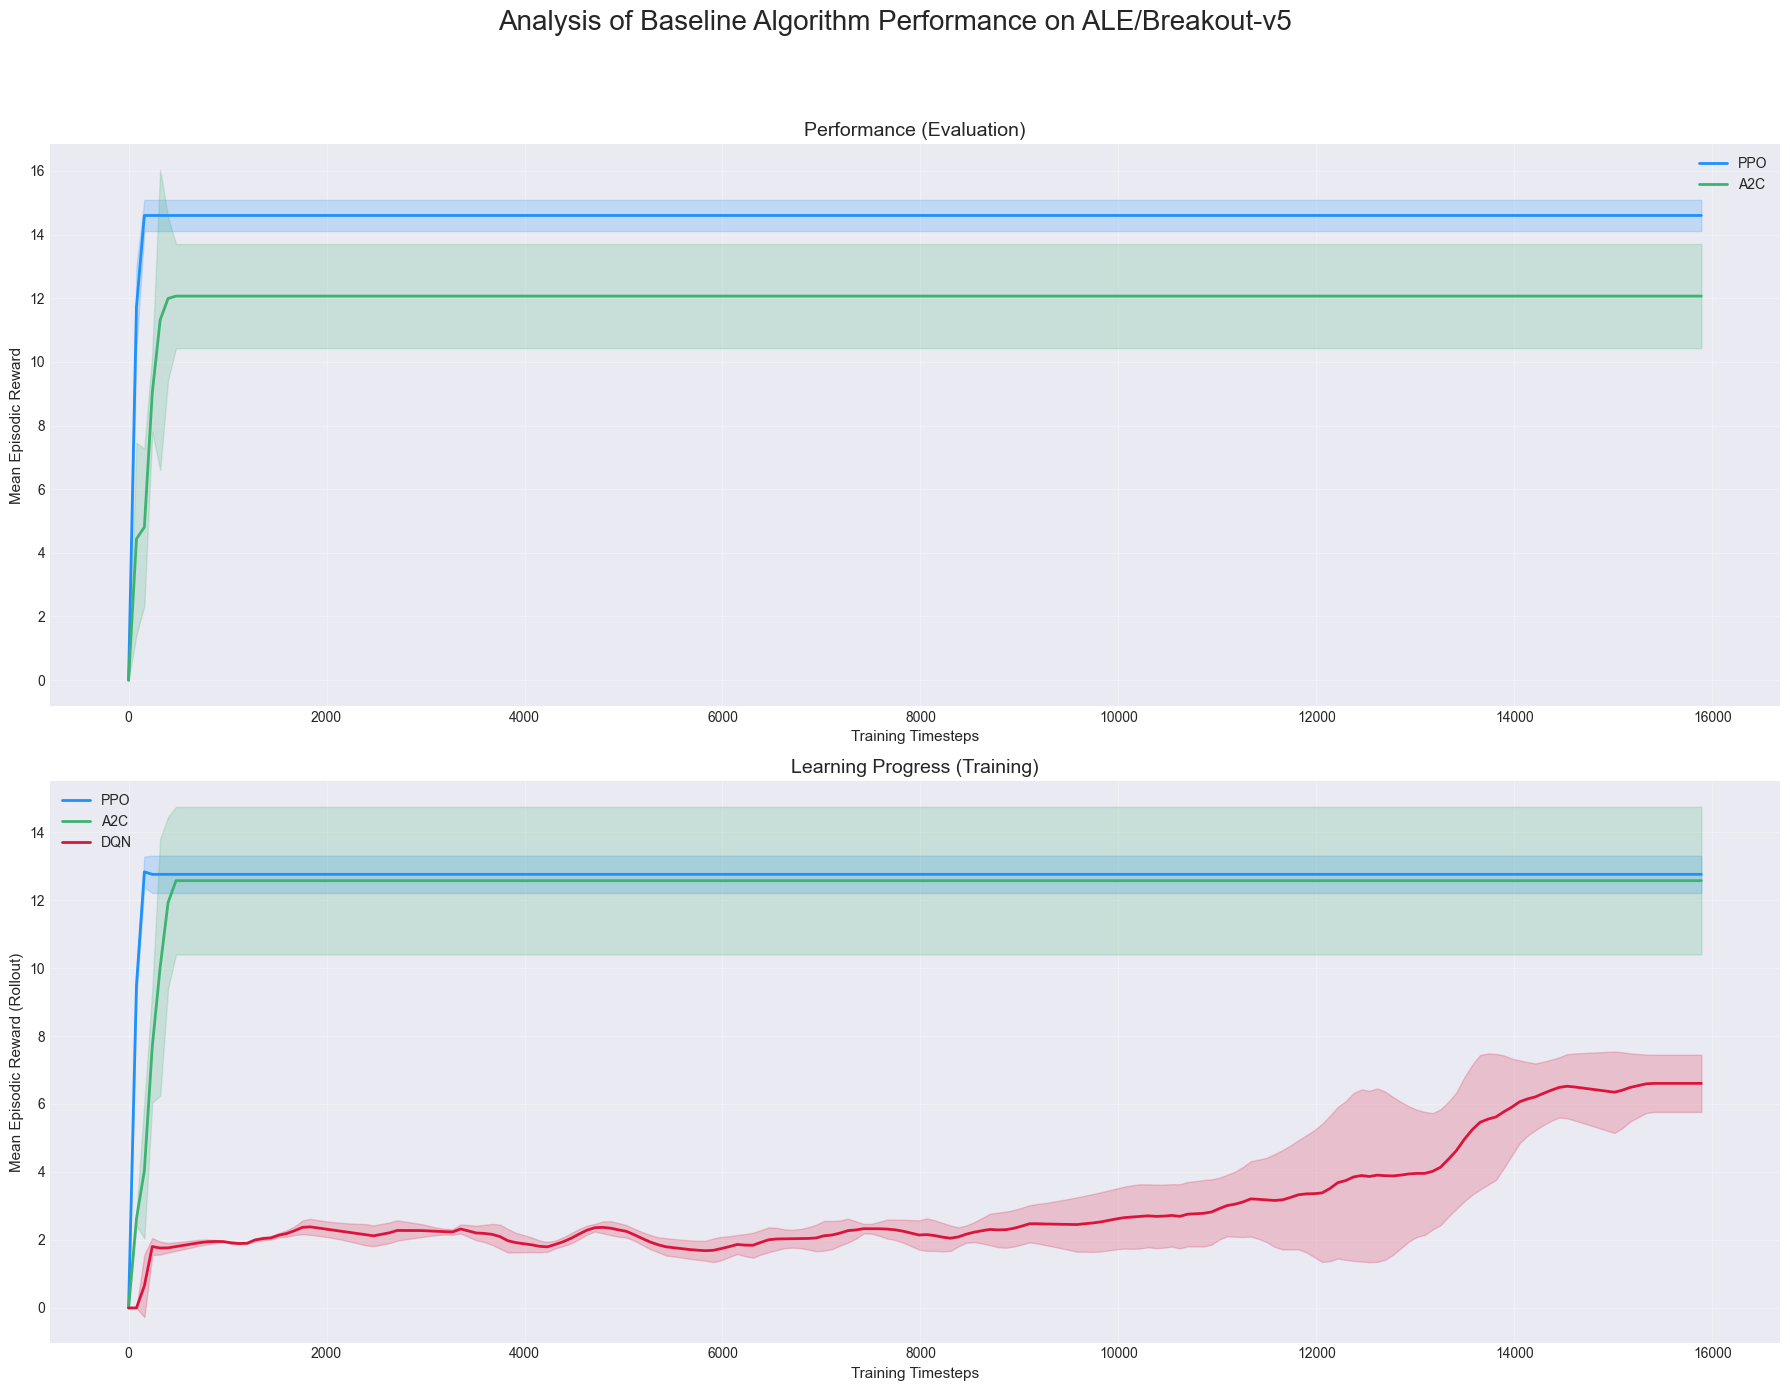

D:\workdir\Temp\ipykernel_38152\667416308.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_runtime_df = full_df[['algorithm', 'run_seed', '_runtime']].dropna().groupby(['algorithm', 'run_seed']).max().reset_index()



--- Baseline Performance Summary ---


,Peak Eval Reward (Avg over seeds),Mean Training Time (minutes)
Algorithm,,
PPO,14.93 ± 0.90,17.3
A2C,13.67 ± 4.30,9.7


In [29]:
# ==============================================================================
#      DEFINITIVE ANALYSIS & PLOTTING CELL
# ==============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# --- Configuration ---
# *** PLEASE UPDATE THIS PATH with your W&B username/entity ***
WANDB_ENTITY = "emontel1-depaul-university"  # <--- REPLACE WITH YOUR W&B USERNAME/ENTITY
# WANDB_PROJECT_NAME should be available from your global setup cell

# --- Connect to W&B API ---
print("Connecting to Weights & Biases API...")
try:
    api = wandb.Api()
    runs_path = f"{WANDB_ENTITY}/{WANDB_PROJECT_NAME}"
    
    # Filter for the "default" baseline runs
    runs = api.runs(path=runs_path, filters={"config.run_type": "default"})
    print(f"Found {len(runs)} baseline runs in project '{WANDB_PROJECT_NAME}'.")
except Exception as e:
    print(f"Error connecting to W&B or finding runs. Please check project path and permissions: {e}")
    runs = []

# --- Loop Through Runs and Aggregate Data ---
all_runs_data = []

if runs:
    print("\nProcessing runs...")
    for run in runs:
        print(f"  - Fetching history for run: {run.name}...")
        
        # Get all columns from the run's history
        history_df = run.history()
        
        # Add config information to each row of the history DataFrame
        # This allows us to easily filter by algorithm, seed, etc. later
        history_df['algorithm'] = run.config.get("algorithm", "unknown")
        history_df['run_seed'] = run.config.get("run_seed", -1)
        history_df['run_name'] = run.name
        
        all_runs_data.append(history_df)
    
    # --- Combine all data into a single DataFrame ---
    if all_runs_data:
        full_df = pd.concat(all_runs_data, ignore_index=True)

        # --- Save the combined data to a CSV file ---
        csv_filename = f"./{RESULTS_DIR}/all_baseline_runs_data.csv"
        full_df.to_csv(csv_filename, index=False)
        print(f"\nSuccessfully downloaded all data and saved to: {csv_filename}")

        # --- Display a sample of the final DataFrame ---
        print("\n--- Sample of the aggregated data (first 5 rows): ---")
        from IPython.display import display
        display(full_df.head())

        print("\n--- Summary of available columns: ---")
        print(full_df.columns.tolist())
        
        print("\n--- Example: Displaying a few rows of evaluation data ---")
        eval_cols = [col for col in full_df.columns if 'eval' in col]
        if eval_cols:
            display(full_df[['_step', 'algorithm', 'run_seed'] + eval_cols].dropna().head())
        else:
            print("No evaluation columns found in the aggregated data.")

    else:
        print("No data was aggregated.")
else:
    print("No runs found to process.")

# --- 1. Load and Preprocess the Data from CSV ---
# RESULTS_DIR should be available from the global setup cell
csv_filename = f"./{RESULTS_DIR}/all_baseline_runs_data.csv"
print(f"Loading data from {csv_filename}...")

try:
    full_df = pd.read_csv(csv_filename)
    # Convert algorithm names to categorical for consistent ordering and plotting
    algo_order = ["PPO", "A2C", "DQN"]
    full_df['algorithm'] = pd.Categorical(full_df['algorithm'], categories=algo_order, ordered=True)
    full_df = full_df.sort_values(by=['algorithm', 'run_seed', '_step'])
    print("Data loaded successfully.")
    print(f"Found data for algorithms: {full_df['algorithm'].unique().tolist()}")
    print(f"Total rows in DataFrame: {len(full_df)}")
except FileNotFoundError:
    print(f"ERROR: The file {csv_filename} was not found. Please ensure the data download script has been run successfully.")
    full_df = pd.DataFrame() # Create empty df to avoid further errors


# --- 2. Helper Function for Plotting ---
def plot_metric(df, metric_col, title, ylabel, ax, is_log_scale=False):
    """Helper function to plot a given metric for all algorithms on a given matplotlib axis."""
    colors = {"PPO": "dodgerblue", "A2C": "mediumseagreen", "DQN": "crimson"}

    for algo_name in df['algorithm'].unique().categories:
        algo_df = df[df['algorithm'] == algo_name].copy()
        
        # Get data for the specific metric, dropping NaNs
        metric_df = algo_df[['_step', 'run_seed', metric_col]].dropna()
        
        if metric_df.empty:
            print(f"No data for metric '{metric_col}' for algorithm '{algo_name}'. Skipping plot.")
            continue
            
        # Create a common step axis for interpolation
        # Use min/max of actual steps for this metric to keep axis relevant
        min_step = 0
        max_step = df['_step'].max()
        # Create more points for a smoother curve
        common_steps = np.linspace(min_step, max_step, num=200)
        
        aligned_runs = []
        for seed in metric_df['run_seed'].unique():
            seed_df = metric_df[metric_df['run_seed'] == seed]
            
            # Interpolate each run's data onto the common step axis
            aligned_run = np.interp(
                common_steps,
                seed_df['_step'],
                seed_df[metric_col],
                left=0,
                right=seed_df[metric_col].iloc[-1] if not seed_df.empty else 0
            )
            aligned_runs.append(aligned_run)

        if aligned_runs:
            rewards_array = np.array(aligned_runs)
            mean_values = np.mean(rewards_array, axis=0)
            std_values = np.std(rewards_array, axis=0)
            
            ax.plot(common_steps, mean_values, label=f"{algo_name}", color=colors.get(algo_name), linewidth=2)
            ax.fill_between(common_steps, mean_values - std_values, mean_values + std_values,
                            alpha=0.2, color=colors.get(algo_name))
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Training Timesteps", fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    if is_log_scale:
        ax.set_yscale('log')
    ax.legend()
    ax.grid(alpha=0.3)


# --- 3. Create Subplots for Key Metrics ---
if not full_df.empty:
    fig, axes = plt.subplots(2, 1, figsize=(18, 14))
    fig.suptitle('Analysis of Baseline Algorithm Performance on ALE/Breakout-v5', fontsize=20, y=1.02)
    axes = axes.flatten()

    # Plot 1: Evaluation Mean Reward (Primary Metric)
    plot_metric(full_df, 'eval/mean_reward', 'Performance (Evaluation)', 'Mean Episodic Reward', axes[0])
    
    # Plot 2: Training Episodic Reward
    plot_metric(full_df, 'rollout/ep_rew_mean', 'Learning Progress (Training)', 'Mean Episodic Reward (Rollout)', axes[1])

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

    # --- 4. Creating Summary Table ---
    summary_data = []
    
    # Calculate average runtime from the raw data
    avg_runtime_df = full_df[['algorithm', 'run_seed', '_runtime']].dropna().groupby(['algorithm', 'run_seed']).max().reset_index()
    
    for algo_name in full_df['algorithm'].unique().categories:
        algo_df = full_df[full_df['algorithm'] == algo_name]
        
        # Best reward is the peak of the mean evaluation learning curve
        eval_df = algo_df[['_step', 'run_seed', 'eval/mean_reward']].dropna()
        if not eval_df.empty:
            mean_of_bests = eval_df.groupby('run_seed')['eval/mean_reward'].max().mean()
            std_of_bests = eval_df.groupby('run_seed')['eval/mean_reward'].max().std()
            
            mean_time_secs = avg_runtime_df[avg_runtime_df['algorithm'] == algo_name]['_runtime'].mean()
            mean_time_mins = mean_time_secs / 60
            
            summary_data.append({
                "Algorithm": algo_name,
                "Peak Eval Reward (Avg over seeds)": f"{mean_of_bests:.2f} ± {std_of_bests:.2f}",
                "Mean Training Time (minutes)": f"{mean_time_mins:.1f}"
            })
            
    summary_df = pd.DataFrame(summary_data).set_index("Algorithm")
    print("\n--- Baseline Performance Summary ---")
    display(summary_df)

else:
    print("DataFrame is empty, cannot generate plots or summary.")